In [20]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from functions.calculate_proximity import calculate_peer_weights
from functions.calculate_monthly_returns import calculate_monthly_returns
from functions.load_datasets import load_datasets
from functions.load_datasets import organize_financial_data_by_year
from functions.load_datasets import sort_columns_chronologically

pd.set_option('future.no_silent_downcasting', True)

In [8]:
base = str(project_root) + "/data/"

config = {
    "df_sales": ("sales.xls", 1),
    "df_capital": ("capital.xls", 1),
}

dfs = {
    name: pd.read_excel(base + file, sheet_name=sheet).rename(columns={"Unnamed: 0": "Company"})
    for name, (file, sheet) in config.items()
}

years = list(range(2025, 2019, -1))
financial_dfs = organize_financial_data_by_year(dfs, years)

In [11]:
df_pbr, df_stp, df_mktcap = load_datasets(base)
df_returns = calculate_monthly_returns(df_stp)

In [ ]:
def create_monthly_feature_data(financial_dfs, df_pbr_sorted):
    """
    毎月の特徴量データを作成

    ルール:
    - 各年の財務データ（financial_dfs[year]）は、year年6月末から利用可能
    - 例: financial_dfs[2020] は 2020/06 から利用可能
    - 2020/01～2020/05 は financial_dfs[2019] を使用
    - 2020/06～2021/05 は financial_dfs[2020] を使用

    リーク防止:
    - t月のデータにはt月以前に利用可能な財務データのみを使用
    """
    pbr_cols = [col for col in df_pbr_sorted.columns if col != 'Company']

    monthly_data = {}

    for month_col in pbr_cols:
        # 月を解析
        year_month = datetime.strptime(month_col, '%Y/%m')
        year = year_month.year
        month = year_month.month

        # 利用可能な財務データの年度を決定
        # 6月以降は当年の財務データ、6月未満は前年の財務データ
        if month >= 6:
            financial_year = year
        else:
            financial_year = year - 1

        # 財務データが存在しない場合はスキップ
        if financial_year not in financial_dfs:
            continue

        # 財務データを取得（インデックスはCompany）
        fin_df = financial_dfs[financial_year].copy()

        # 空のDataFrameの場合はスキップ
        if len(fin_df) == 0:
            continue

        # PBRデータを取得（この月のPBR）
        # Company列をインデックスに設定してマージできるようにする
        pbr_df = df_pbr_sorted[['Company', month_col]].copy()
        pbr_df = pbr_df.set_index('Company')
        pbr_series = pbr_df[month_col]

        # log_PBRを計算（0や負の値をNaNに変換）
        log_pbr = np.log(pbr_series.replace([0, np.inf, -np.inf], np.nan))

        # インデックス（Company）でマージ
        merged_df = fin_df.copy()
        merged_df['log_pbr'] = log_pbr

        # 欠損値を除外
        merged_df = merged_df.dropna()

        monthly_data[month_col] = merged_df

    return monthly_data

monthly_feature_data = create_monthly_feature_data(financial_dfs, df_pbr)

print(f"月次特徴量データの作成完了")
print(f"利用可能な月数: {len(monthly_feature_data)}")

# データ構造の確認
available_months = sorted(monthly_feature_data.keys())
if len(available_months) > 0:
    print(f"\n最初の月: {available_months[0]}")
    print(f"最後の月: {available_months[-1]}")
    print(f"\n例 (2021/01): 形状 = {monthly_feature_data.get('2021/01', pd.DataFrame()).shape if '2021/01' in monthly_feature_data else 'なし'}")
    if '2021/01' in monthly_feature_data:
        print(f"  → 使用財務データ: 2020年度 (2020/06から利用可能)")
    print(f"\n例 (2021/06): 形状 = {monthly_feature_data.get('2021/06', pd.DataFrame()).shape if '2021/06' in monthly_feature_data else 'なし'}")
    if '2021/06' in monthly_feature_data:
        print(f"  → 使用財務データ: 2021年度 (2021/06から利用可能)")

月次特徴量データの作成完了
利用可能な月数: 67

最初の月: 2020/06
最後の月: 2025/12

例 (2021/01): 形状 = (3121, 3)
  → 使用財務データ: 2020年度 (2020/06から利用可能)

例 (2021/06): 形状 = (3164, 3)
  → 使用財務データ: 2021年度 (2021/06から利用可能)


In [13]:
# ML戦略: 類似企業加重平均PBRに対する相対PBRを計算
def create_ml_relative_pbr_strategy(monthly_feature_data, df_pbr_sorted, df_returns,
                                      n_quintiles=5, lookback_months=12, top_k=10):
    """
    LightGBMとProximityを使った類似企業ベースの相対PBR戦略

    リーク防止:
    - t月のポートフォリオ形成には、t月以前のデータのみを使用
    - 学習データは過去lookback_months分
    - 財務データは6月末から利用可能なルールに従う

    Parameters:
    -----------
    monthly_feature_data : dict
        月ごとの特徴量データ（財務データ+log_PBR）
    df_pbr_sorted : DataFrame
        PBRデータ（時系列順）
    df_returns : DataFrame
        月次リターンデータ
    n_quintiles : int
        分位数
    lookback_months : int
        学習に使用する過去月数
    top_k : int
        類似企業の数

    Returns:
    --------
    DataFrame
        各分位の月次リターン
    """
    pbr_cols = [col for col in df_pbr_sorted.columns if col != 'Company']
    return_cols = [col for col in df_returns.columns if col.startswith('ret_')]

    portfolio_returns = {f'Q{i+1}': [] for i in range(n_quintiles)}
    portfolio_returns['Date'] = []

    # 利用可能な月のリスト
    available_months = sorted([m for m in monthly_feature_data.keys()])

    # 各月について処理（十分な学習データがある月から開始）
    for i in range(len(pbr_cols) - 1):
        formation_month = pbr_cols[i]
        return_month = return_cols[i]

        portfolio_returns['Date'].append(return_month.replace('ret_', ''))

        print(f"\n処理中: {formation_month} → {return_month.replace('ret_', '')}")

        # 現在月のデータが利用可能かチェック
        if formation_month not in monthly_feature_data:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            print(f"  ⚠ {formation_month} のデータなし（財務データ利用不可）")
            continue

        current_df = monthly_feature_data[formation_month].copy()

        # 過去lookback_months分のデータを学習データとして収集
        # formation_monthより前の月のみを使用（リーク防止）
        formation_idx = available_months.index(formation_month) if formation_month in available_months else -1

        if formation_idx < 0:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            print(f"  ⚠ {formation_month} がavailable_monthsに存在しない")
            continue

        # 過去のデータのみを使用
        past_months = available_months[max(0, formation_idx - lookback_months):formation_idx]

        train_dfs = []
        for past_month in past_months:
            if past_month in monthly_feature_data:
                train_dfs.append(monthly_feature_data[past_month])

        if len(train_dfs) == 0:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            print(f"  ⚠ 学習データなし")
            continue

        train_df = pd.concat(train_dfs, axis=0)
        print(f"  学習データ: {len(train_dfs)}ヶ月分、{len(train_df)}サンプル")

        # calculate_peer_weightsで類似度を計算
        try:
            weights_df = calculate_peer_weights(
                train_df=train_df,
                current_features_df=current_df,
                top_k=top_k,
                num_boost_round=100
            )
        except Exception as e:
            print(f"  ⚠ Proximity計算エラー: {e}")
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            continue

        if weights_df is None:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            print(f"  ⚠ weights_df が None")
            continue

        # 各企業の実際のPBRを取得（formation_monthのPBR）
        pbr_series = df_pbr_sorted.set_index('Company')[formation_month]

        # weights_dfのインデックスと一致する企業のみを対象
        common_companies = weights_df.index.intersection(pbr_series.index)

        if len(common_companies) == 0:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            print(f"  ⚠ 共通企業なし")
            continue

        # 類似企業の加重平均PBRを計算
        weights_subset = weights_df.loc[common_companies, common_companies]
        pbr_subset = pbr_series.loc[common_companies]

        peer_avg_pbr = weights_subset @ pbr_subset
        peer_avg_pbr = peer_avg_pbr.fillna(pbr_subset.mean())

        # 相対PBR = 自社PBR / 類似企業平均PBR
        relative_pbr = pbr_subset / peer_avg_pbr

        # リターンデータを取得
        return_series = df_returns.set_index('Company')[return_month]

        # マージ
        temp_df = pd.DataFrame({
            'Company': relative_pbr.index,
            'Relative_PBR': relative_pbr.values,
            'Return': return_series.reindex(relative_pbr.index).values
        })

        temp_df = temp_df.dropna()

        if len(temp_df) < n_quintiles:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            print(f"  ⚠ データ不足: {len(temp_df)}社")
            continue

        # 相対PBRで5分位に分割
        try:
            temp_df['Quintile'] = pd.qcut(temp_df['Relative_PBR'], q=n_quintiles, labels=False, duplicates='drop')
        except Exception as e:
            print(f"  ⚠ 分位分割エラー: {e}")
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            continue

        # 各分位の等加重平均リターンを計算
        for q in range(n_quintiles):
            quintile_returns = temp_df[temp_df['Quintile'] == q]['Return']
            avg_return = quintile_returns.mean() if len(quintile_returns) > 0 else np.nan
            portfolio_returns[f'Q{q+1}'].append(avg_return)

        print(f"  ✓ 完了: {len(temp_df)}社、分位別サンプル数 {[len(temp_df[temp_df['Quintile'] == q]) for q in range(n_quintiles)]}")

    result_df = pd.DataFrame(portfolio_returns)
    result_df = result_df.set_index('Date')

    return result_df

# ML戦略を実行
print("=" * 80)
print("ML戦略（類似企業ベース相対PBR）の実行")
print("=" * 80)
print("注: 財務データは決算後3ヶ月（6月末）から利用可能")
print("=" * 80)

quintile_returns_ml = create_ml_relative_pbr_strategy(
    monthly_feature_data=monthly_feature_data,
    df_pbr_sorted=df_pbr,
    df_returns=df_returns,
    n_quintiles=5,
    lookback_months=12,
    top_k=10
)

print("\n" + "=" * 80)
print("ML戦略の構築完了")
print("=" * 80)
print(f"期間: {quintile_returns_ml.index[0]} ～ {quintile_returns_ml.index[-1]}")
print(f"観測数: {len(quintile_returns_ml)}")
print(f"\n最初の10行:")
print(quintile_returns_ml.head(10))

ML戦略（類似企業ベース相対PBR）の実行
注: 財務データは決算後3ヶ月（6月末）から利用可能

処理中: 2020/01 → 2020/02
  ⚠ 2020/01 のデータなし（財務データ利用不可）

処理中: 2020/02 → 2020/03
  ⚠ 2020/02 のデータなし（財務データ利用不可）

処理中: 2020/03 → 2020/04
  ⚠ 2020/03 のデータなし（財務データ利用不可）

処理中: 2020/04 → 2020/05
  ⚠ 2020/04 のデータなし（財務データ利用不可）

処理中: 2020/05 → 2020/06
  ⚠ 2020/05 のデータなし（財務データ利用不可）

処理中: 2020/06 → 2020/07
  ⚠ 学習データなし

処理中: 2020/07 → 2020/08
  学習データ: 1ヶ月分、3119サンプル
corr: 0.7485, rmse: 0.6712
  ✓ 完了: 3120社、分位別サンプル数 [624, 624, 624, 624, 624]

処理中: 2020/08 → 2020/09
  学習データ: 2ヶ月分、6240サンプル
corr: 0.7936, rmse: 0.6521
  ✓ 完了: 3120社、分位別サンプル数 [624, 624, 624, 624, 624]

処理中: 2020/09 → 2020/10
  学習データ: 3ヶ月分、9362サンプル
corr: 0.8119, rmse: 0.6387
  ✓ 完了: 3116社、分位別サンプル数 [624, 623, 623, 623, 623]

処理中: 2020/10 → 2020/11
  学習データ: 4ヶ月分、12480サンプル
corr: 0.8067, rmse: 0.6275
  ✓ 完了: 3121社、分位別サンプル数 [625, 624, 624, 624, 624]

処理中: 2020/11 → 2020/12
  学習データ: 5ヶ月分、15602サンプル
corr: 0.8114, rmse: 0.6295
  ✓ 完了: 3124社、分位別サンプル数 [625, 625, 624, 625, 625]

処理中: 2020/12 → 2021/01
  学習

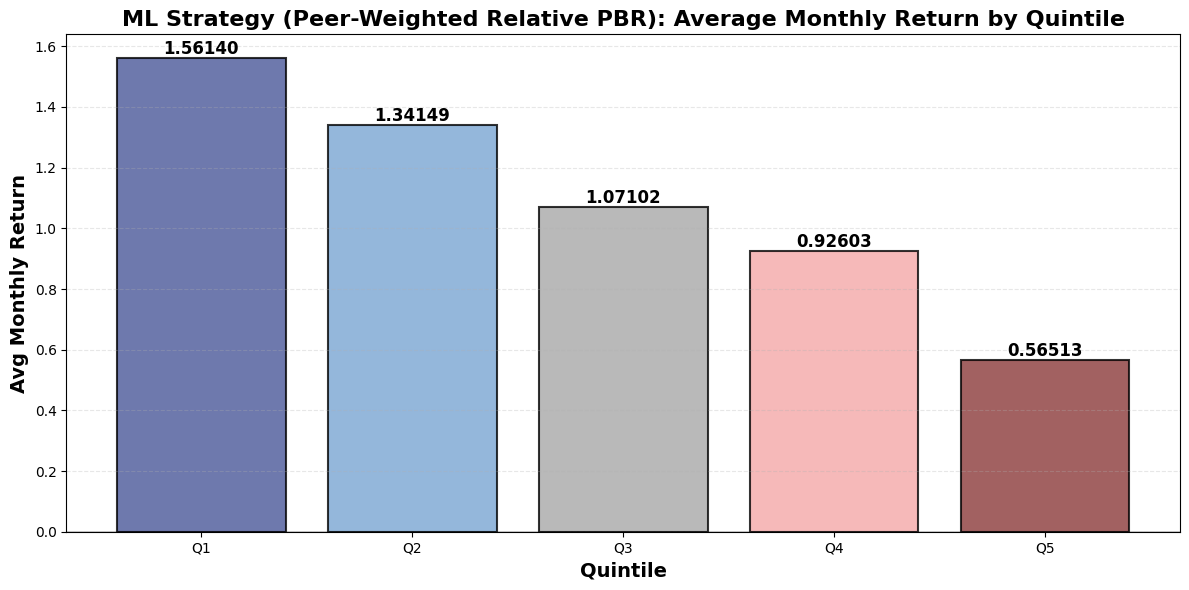


各分位の平均月次リターン（ML戦略）:
Q1: 1.56140 (156.140%)
Q2: 1.34149 (134.149%)
Q3: 1.07102 (107.102%)
Q4: 0.92603 (92.603%)
Q5: 0.56513 (56.513%)


In [14]:
# 図1: ML戦略 - 平均月次リターンのヒストグラム
plt.figure(figsize=(12, 6))

mean_returns_ml = quintile_returns_ml.mean()
colors = ['#4A5899', '#7AA5D2', '#A8A8A8', '#F4A8A8', '#8B3A3A']

bars = plt.bar(mean_returns_ml.index, mean_returns_ml.values,
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

plt.xlabel('Quintile', fontsize=14, fontweight='bold')
plt.ylabel('Avg Monthly Return', fontsize=14, fontweight='bold')
plt.title('ML Strategy (Peer-Weighted Relative PBR): Average Monthly Return by Quintile',
          fontsize=16, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.5f}', ha='center', va='bottom' if height > 0 else 'top',
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n各分位の平均月次リターン（ML戦略）:")
for q, ret in mean_returns_ml.items():
    print(f"{q}: {ret:.5f} ({ret*100:.3f}%)")

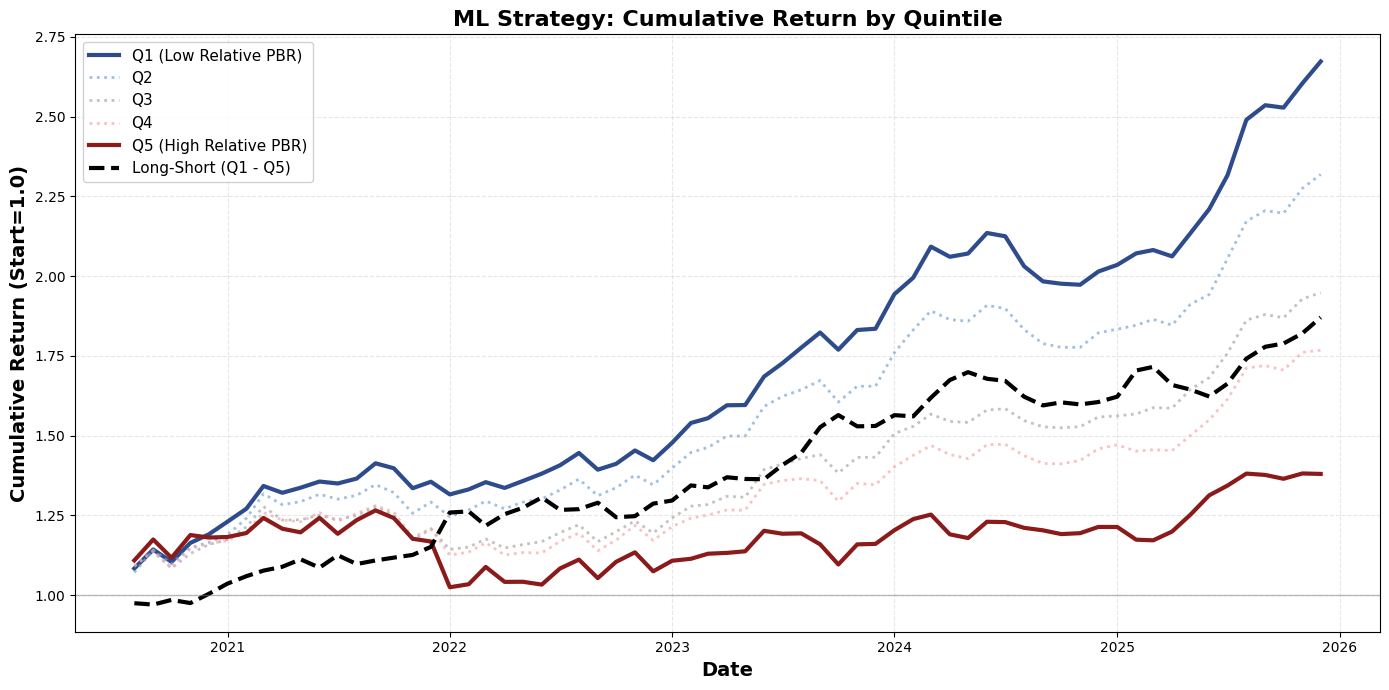


最終累積リターン（ML戦略、開始=1.0）:
Q1: 2.6725 (累積リターン: +167.25%)
Q2: 2.3188 (累積リターン: +131.88%)
Q3: 1.9478 (累積リターン: +94.78%)
Q4: 1.7676 (累積リターン: +76.76%)
Q5: 1.3800 (累積リターン: +38.00%)
Long-Short (Q1-Q5): 1.8705 (累積リターン: +87.05%)


In [15]:
# 図2: ML戦略 - 累積リターンの推移
plt.figure(figsize=(14, 7))

# 累積リターンを計算
cumulative_returns_ml = (1 + quintile_returns_ml / 100).cumprod()

# Long-Short ポートフォリオ
long_short_returns_ml = quintile_returns_ml['Q1'] - quintile_returns_ml['Q5']
cumulative_long_short_ml = (1 + long_short_returns_ml / 100).cumprod()

# 日付インデックス
dates = pd.to_datetime(cumulative_returns_ml.index, format='%Y/%m')

# プロット
plt.plot(dates, cumulative_returns_ml['Q1'], linewidth=3, color='#2E4C8B',
         label='Q1 (Low Relative PBR)', linestyle='-')
plt.plot(dates, cumulative_returns_ml['Q2'], linewidth=2, color='#7AA5D2',
         label='Q2', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_ml['Q3'], linewidth=2, color='#A8A8A8',
         label='Q3', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_ml['Q4'], linewidth=2, color='#F4A8A8',
         label='Q4', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_ml['Q5'], linewidth=3, color='#8B1A1A',
         label='Q5 (High Relative PBR)', linestyle='-')
plt.plot(dates, cumulative_long_short_ml, linewidth=3, color='black',
         label='Long-Short (Q1 - Q5)', linestyle='--')

plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Return (Start=1.0)', fontsize=14, fontweight='bold')
plt.title('ML Strategy: Cumulative Return by Quintile', fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(y=1, color='gray', linestyle='-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# 最終累積リターン
print("\n最終累積リターン（ML戦略、開始=1.0）:")
for col in cumulative_returns_ml.columns:
    final_return = cumulative_returns_ml[col].iloc[-1]
    total_return_pct = (final_return - 1) * 100
    print(f"{col}: {final_return:.4f} (累積リターン: {total_return_pct:+.2f}%)")

final_ls_ml = cumulative_long_short_ml.iloc[-1]
total_ls_pct_ml = (final_ls_ml - 1) * 100
print(f"Long-Short (Q1-Q5): {final_ls_ml:.4f} (累積リターン: {total_ls_pct_ml:+.2f}%)")

In [16]:
# ML戦略のバリュープレミアム統計分析
value_premium_ml = quintile_returns_ml['Q1'] - quintile_returns_ml['Q5']

print("\n" + "=" * 80)
print("ML戦略のバリュープレミアム（Q1 - Q5）の統計分析")
print("=" * 80)
print(f"平均月次プレミアム: {value_premium_ml.mean():.5f} ({value_premium_ml.mean()*100:.3f}%)")
print(f"標準偏差: {value_premium_ml.std():.5f}")
print(f"t値: {value_premium_ml.mean() / (value_premium_ml.std() / np.sqrt(len(value_premium_ml))):.4f}")

# t検定
t_stat_ml, p_value_ml = stats.ttest_1samp(value_premium_ml.dropna(), 0)
print(f"p値: {p_value_ml:.6f}")

if p_value_ml < 0.01:
    sig_ml = '***'
elif p_value_ml < 0.05:
    sig_ml = '**'
elif p_value_ml < 0.1:
    sig_ml = '*'
else:
    sig_ml = ''

print(f"有意性: {sig_ml} ({'有意' if sig_ml else '有意でない'})")
print(f"\n勝率（プレミアムが正の月）: {(value_premium_ml > 0).sum() / len(value_premium_ml) * 100:.2f}%")
print("=" * 80)


ML戦略のバリュープレミアム（Q1 - Q5）の統計分析
平均月次プレミアム: 0.99627 (99.627%)
標準偏差: 2.41218
t値: 3.4801
p値: 0.001445
有意性: *** (有意)

勝率（プレミアムが正の月）: 61.97%


In [17]:
# シャープレシオの計算
print("\n" + "=" * 80)
print("シャープレシオの計算（リスクフリーレート = 0と仮定）")
print("=" * 80)

# 各分位のシャープレシオ
sharpe_ratios_ml = {}
for col in quintile_returns_ml.columns:
    mean_return = quintile_returns_ml[col].mean()
    std_return = quintile_returns_ml[col].std()
    sharpe_monthly = mean_return / std_return if std_return > 0 else 0
    sharpe_annual = sharpe_monthly * np.sqrt(12)
    sharpe_ratios_ml[col] = {
        '月次': sharpe_monthly,
        '年率換算': sharpe_annual
    }

# Long-Short戦略
ls_ml_mean = value_premium_ml.mean()
ls_ml_std = value_premium_ml.std()
ls_ml_sharpe_monthly = ls_ml_mean / ls_ml_std if ls_ml_std > 0 else 0
ls_ml_sharpe_annual = ls_ml_sharpe_monthly * np.sqrt(12)

sharpe_ratios_ml['Long-Short (Q1-Q5)'] = {
    '月次': ls_ml_sharpe_monthly,
    '年率換算': ls_ml_sharpe_annual
}

sharpe_df_ml = pd.DataFrame(sharpe_ratios_ml).T
print("\nシャープレシオ:")
print(sharpe_df_ml.to_string())

print("\n" + "=" * 80)
print("解釈:")
print("-" * 80)
print("- シャープレシオ = 平均リターン / リターンの標準偏差")
print("- リスク調整後のパフォーマンスを測定")
print("- 一般的に、シャープレシオ > 1 は良好、> 2 は優秀とされる")
print("- 年率換算 = 月次シャープレシオ × sqrt(12)")
print("=" * 80)


シャープレシオの計算（リスクフリーレート = 0と仮定）

シャープレシオ:
                          月次      年率換算
Q1                  0.561736  1.945911
Q2                  0.473107  1.638889
Q3                  0.374542  1.297453
Q4                  0.302994  1.049603
Q5                  0.152155  0.527080
Long-Short (Q1-Q5)  0.413017  1.430733

解釈:
--------------------------------------------------------------------------------
- シャープレシオ = 平均リターン / リターンの標準偏差
- リスク調整後のパフォーマンスを測定
- 一般的に、シャープレシオ > 1 は良好、> 2 は優秀とされる
- 年率換算 = 月次シャープレシオ × sqrt(12)


In [18]:
# ===================================================================
# Fama-French 3ファクターモデルによるアルファ検証
# ===================================================================

print("時価総額データの形状:", df_mktcap.shape)
print("\n時価総額データの最初の数行:")
print(df_mktcap.head())

# 列名のマッピング（P → 2025, P-1 → 2024, ...）
# P, P-1, P-2, ... の形式を YYYY/MM に変換
def map_mktcap_columns(df_mktcap):
    """
    時価総額データの列名を年/月形式に変換
    P → 2025, P-1 → 2024, P-2 → 2023, ...
    """
    new_columns = {'Company': 'Company'}

    for col in df_mktcap.columns:
        if col == 'Company':
            continue

        if col == 'P':
            # P → 2025年（決算月を12月と仮定）
            new_columns[col] = '2025/12'
        elif col.startswith('P-'):
            # P-1 → 2024, P-2 → 2023, ...
            offset = int(col.split('-')[1])
            year = 2025 - offset
            new_columns[col] = f'{year}/12'

    df_renamed = df_mktcap.rename(columns=new_columns)
    return df_renamed

df_mktcap_renamed = map_mktcap_columns(df_mktcap)

print("\n列名マッピング後:")
print(df_mktcap_renamed.columns.tolist()[:10])

時価総額データの形状: (4103, 22)

時価総額データの最初の数行:
          Company             P           P-1           P-2           P-3  \
0     あい　ホールディングス  146023190000  1.481009e+11  1.427736e+11  1.492730e+11   
1  あいちフィナンシャルグループ  221001040000  2.263616e+11  1.937119e+11  1.522892e+11   
2          あおぞら銀行  330730920000  3.341904e+11  3.051995e+11  3.203522e+11   
3          あかつき本社   16859880000  1.713170e+10  1.619341e+10  1.658689e+10   
4       あさかわシステムズ    1316340000  1.316340e+09  1.316340e+09  1.316340e+09   

            P-4           P-5           P-6           P-7           P-8  ...  \
0  1.373930e+11  1.289765e+11  1.249277e+11  1.226369e+11  1.125690e+11  ...   
1  1.426889e+11  1.324761e+11  1.235860e+11  1.259233e+11  1.335867e+11  ...   
2  3.170311e+11  3.068601e+11  2.991799e+11  2.900468e+11  2.719188e+11  ...   
3  1.688957e+10  1.607234e+10  1.525510e+10  1.501295e+10  1.474057e+10  ...   
4  1.316340e+09  1.316340e+09  1.316340e+09  1.316340e+09  1.316340e+09  ...   

           P-11  

In [21]:
# 時系列順に並び替え
df_mktcap_sorted = sort_columns_chronologically(df_mktcap_renamed)

print("時価総額データを時系列順に並び替え完了")
print(f"列の例: {df_mktcap_sorted.columns.tolist()[1:11]}")

# Fama-French 3ファクターの構築
def construct_ff3_factors(df_pbr_sorted, df_stp_sorted, df_mktcap_sorted, df_returns):
    """
    Fama-French 3ファクターを構築

    Factors:
    1. Mkt-Rf: 市場超過リターン（時価総額加重市場リターン）
    2. SMB (Small Minus Big): 小型株 - 大型株
    3. HML (High Minus Low): 高PBR株 - 低PBR株（バリュー - グロース）

    Parameters:
    -----------
    df_pbr_sorted : DataFrame
        PBRデータ
    df_stp_sorted : DataFrame
        株価データ
    df_mktcap_sorted : DataFrame
        時価総額データ
    df_returns : DataFrame
        リターンデータ

    Returns:
    --------
    DataFrame
        月次ファクターリターン
    """
    pbr_cols = [col for col in df_pbr_sorted.columns if col != 'Company']
    return_cols = [col for col in df_returns.columns if col.startswith('ret_')]

    factors = {
        'Date': [],
        'Mkt_Rf': [],
        'SMB': [],
        'HML': []
    }

    for i in range(len(pbr_cols) - 1):
        formation_month = pbr_cols[i]
        return_month = return_cols[i]

        factors['Date'].append(return_month.replace('ret_', ''))

        # 時価総額でソート用のデータを取得
        # formation_monthに最も近い時価総額データを使用
        if formation_month not in df_mktcap_sorted.columns:
            # 利用可能な最も近い過去の月を使用
            available_mktcap_cols = [col for col in df_mktcap_sorted.columns if col != 'Company' and col <= formation_month]
            if len(available_mktcap_cols) == 0:
                factors['Mkt_Rf'].append(np.nan)
                factors['SMB'].append(np.nan)
                factors['HML'].append(np.nan)
                continue
            mktcap_month = available_mktcap_cols[-1]
        else:
            mktcap_month = formation_month

        # データを統合
        temp_df = pd.DataFrame({
            'Company': df_pbr_sorted['Company'],
            'PBR': df_pbr_sorted[formation_month],
            'MktCap': df_mktcap_sorted[mktcap_month],
            'Return': df_returns[return_month]
        })

        temp_df = temp_df.dropna()

        if len(temp_df) < 10:
            factors['Mkt_Rf'].append(np.nan)
            factors['SMB'].append(np.nan)
            factors['HML'].append(np.nan)
            continue

        # 1. Mkt-Rf: 時価総額加重市場リターン
        total_mktcap = temp_df['MktCap'].sum()
        temp_df['Weight'] = temp_df['MktCap'] / total_mktcap
        mkt_return = (temp_df['Weight'] * temp_df['Return']).sum()
        factors['Mkt_Rf'].append(mkt_return)

        # 2. SMB: 時価総額で2分割
        median_mktcap = temp_df['MktCap'].median()
        small_stocks = temp_df[temp_df['MktCap'] <= median_mktcap]
        big_stocks = temp_df[temp_df['MktCap'] > median_mktcap]

        smb = small_stocks['Return'].mean() - big_stocks['Return'].mean()
        factors['SMB'].append(smb)

        # 3. HML: PBRで3分割（High 30%, Middle 40%, Low 30%）
        pbr_30 = temp_df['PBR'].quantile(0.3)
        pbr_70 = temp_df['PBR'].quantile(0.7)

        low_pbr = temp_df[temp_df['PBR'] <= pbr_30]  # Value
        high_pbr = temp_df[temp_df['PBR'] >= pbr_70]  # Growth

        hml = low_pbr['Return'].mean() - high_pbr['Return'].mean()
        factors['HML'].append(hml)

    factors_df = pd.DataFrame(factors).set_index('Date')

    return factors_df

# FF3ファクターを構築
print("=" * 80)
print("Fama-French 3ファクターの構築")
print("=" * 80)

ff3_factors = construct_ff3_factors(df_pbr, df_stp, df_mktcap_sorted, df_returns)

print(f"\nファクターデータの形状: {ff3_factors.shape}")
print(f"期間: {ff3_factors.index[0]} ～ {ff3_factors.index[-1]}")
print(f"\n最初の10行:")
print(ff3_factors.head(10))
print(f"\n基本統計量:")
print(ff3_factors.describe())

時価総額データを時系列順に並び替え完了
列の例: ['2005/12', '2006/12', '2007/12', '2008/12', '2009/12', '2010/12', '2011/12', '2012/12', '2013/12', '2014/12']
Fama-French 3ファクターの構築

ファクターデータの形状: (71, 3)
期間: 2020/02 ～ 2025/12

最初の10行:
            Mkt_Rf       SMB       HML
Date                                  
2020/02 -16.015868  0.046011  4.536637
2020/03  -8.528069 -0.067793  1.626978
2020/04   8.739781  0.059588 -8.469022
2020/05   9.705065 -0.144058 -8.072517
2020/06   5.948743  0.231815 -3.298110
2020/07  -6.553331  0.138106  0.237491
2020/08   7.118863  0.531469 -4.720607
2020/09   4.619320 -0.092633 -2.758230
2020/10  -3.612111 -0.176493  2.499939
2020/11   3.465025  0.143174 -0.957475

基本統計量:
          Mkt_Rf        SMB        HML
count  71.000000  71.000000  71.000000
mean    0.931839  -0.043561   0.683960
std     3.933506   0.304656   3.181284
min   -16.015868  -0.654800  -8.469022
25%    -0.857697  -0.252974  -1.249505
50%     1.288395  -0.017889   0.687891
75%     3.017278   0.159031   2.983691
m

In [22]:
# FF3回帰分析
import statsmodels.api as sm

print("\n" + "=" * 80)
print("Fama-French 3ファクターモデルによる回帰分析")
print("=" * 80)

# ロングショート戦略のリターンとFF3ファクターをマージ
regression_data = pd.DataFrame({
    'LS_Return': value_premium_ml,
    'Mkt_Rf': ff3_factors['Mkt_Rf'],
    'SMB': ff3_factors['SMB'],
    'HML': ff3_factors['HML']
})

# 欠損値を除外
regression_data = regression_data.dropna()

print(f"\n回帰分析用データ:")
print(f"  サンプル数: {len(regression_data)}")
print(f"  期間: {regression_data.index[0]} ～ {regression_data.index[-1]}")

if len(regression_data) < 10:
    print("\n⚠ サンプル数が不足しています")
else:
    # 説明変数
    X = regression_data[['Mkt_Rf', 'SMB', 'HML']]
    X = sm.add_constant(X)  # 定数項を追加

    # 被説明変数
    y = regression_data['LS_Return']

    # OLS回帰
    model = sm.OLS(y, X)
    results = model.fit()

    print("\n" + "-" * 80)
    print("回帰結果:")
    print("-" * 80)
    print(results.summary())

    # アルファの抽出
    alpha = results.params['const']
    alpha_tstat = results.tvalues['const']
    alpha_pvalue = results.pvalues['const']

    print("\n" + "=" * 80)
    print("【アルファの統計的有意性】")
    print("=" * 80)
    print(f"アルファ (月次): {alpha:.6f} ({alpha * 100:.4f}%)")
    print(f"アルファ (年率): {alpha * 12:.6f} ({alpha * 12 * 100:.4f}%)")
    print(f"t値: {alpha_tstat:.4f}")
    print(f"p値: {alpha_pvalue:.6f}")

    if alpha_pvalue < 0.01:
        sig = '***'
        conclusion = "統計的に非常に有意（p < 0.01）"
    elif alpha_pvalue < 0.05:
        sig = '**'
        conclusion = "統計的に有意（p < 0.05）"
    elif alpha_pvalue < 0.1:
        sig = '*'
        conclusion = "統計的にやや有意（p < 0.1）"
    else:
        sig = ''
        conclusion = "統計的に有意でない（p >= 0.1）"

    print(f"有意性: {sig}")
    print(f"\n結論: アルファは{conclusion}")

    if alpha > 0 and alpha_pvalue < 0.05:
        print("→ ML戦略は市場、サイズ、バリューファクターでは説明できない")
        print("  統計的に有意な超過リターン（アルファ）を生成しています。")
    elif alpha > 0 and alpha_pvalue < 0.1:
        print("→ ML戦略はやや有意な超過リターンを示しています。")
    else:
        print("→ ML戦略の超過リターンは統計的に有意ではありません。")

    print("\n" + "-" * 80)
    print("ファクターローディング:")
    print("-" * 80)
    print(f"市場ファクター (Mkt-Rf): {results.params['Mkt_Rf']:.4f} (t={results.tvalues['Mkt_Rf']:.2f})")
    print(f"サイズファクター (SMB):  {results.params['SMB']:.4f} (t={results.tvalues['SMB']:.2f})")
    print(f"バリューファクター (HML): {results.params['HML']:.4f} (t={results.tvalues['HML']:.2f})")

    print("\n" + "-" * 80)
    print("モデル適合度:")
    print("-" * 80)
    print(f"R-squared: {results.rsquared:.4f}")
    print(f"Adjusted R-squared: {results.rsquared_adj:.4f}")
    print("=" * 80)


Fama-French 3ファクターモデルによる回帰分析

回帰分析用データ:
  サンプル数: 65
  期間: 2020/08 ～ 2025/12

--------------------------------------------------------------------------------
回帰結果:
--------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:              LS_Return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     103.1
Date:                Tue, 20 Jan 2026   Prob (F-statistic):           7.52e-24
Time:                        10:25:35   Log-Likelihood:                -90.356
No. Observations:                  65   AIC:                             188.7
Df Residuals:                      61   BIC:                             197.4
Df Model:                           3                                         
Covariance Type:            nonrobust      